<a href="https://colab.research.google.com/github/apolloaggrey/GANs/blob/main/playground_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import math
import torch
import pickle
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'
# manuals seed for repeatability
torch.manual_seed(111)

In [ ]:
# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# Define a transform to convert the images to tensors and normalize them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

Using cuda device


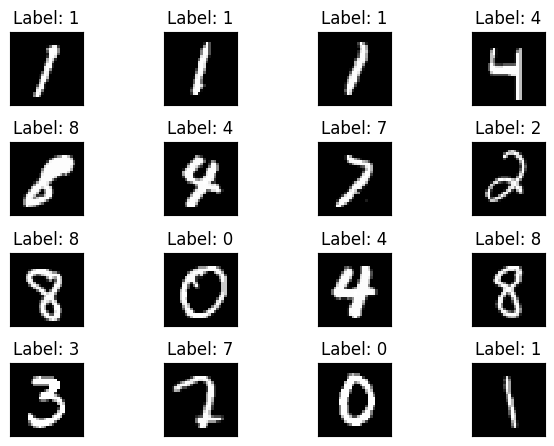

In [ ]:

# Create a train_set object which is an instance of the MNIST dataset
train_set = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Set the batch size for training
batch_size = 32

# Create a DataLoader object for the training set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# Get the first batch of images and labels from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot 16 images from the batch
fig = plt.figure()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap="gray", interpolation="none")
    plt.title(f"Label: {labels[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:

# Define the Discriminator class which inherits from nn.Module
class Discriminator(nn.Module):
    def __init__(self):
        # Call the parent class constructor
        super().__init__()
        # Define the model architecture as a sequence of layers
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Reshape the input tensor to have a size of (batch_size, 784)
        x = x.view(x.size(0), 784)
        # Pass the input through the model
        output = self.model(x)
        return output


# Create an instance of the Discriminator class and move it to the specified device
discriminator = Discriminator().to(device)

In [ ]:

# Define the Generator class which inherits from nn.Module
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

# Create an instance of the Generator class and move it to the specified device
generator = Generator().to(device)


In [ ]:

# Set the learning rate and number of training epochs
lr = 0.0001
epochs = 10

# Define the loss function
loss_function = nn.BCELoss()

# Create optimizers for the discriminator and generator
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)


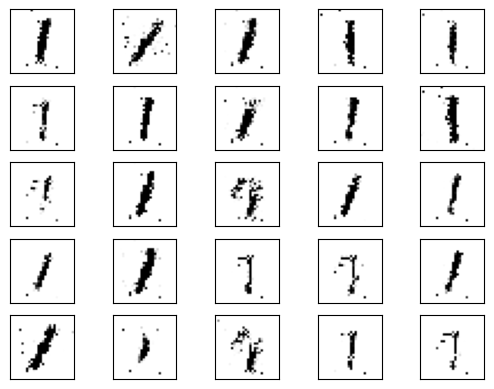

In [ ]:
from IPython import display
# Generate random latent space samples
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
# Generate fake samples using the generator
generated_samples = generator(latent_space_samples)

# Move the generated samples to the CPU and detach them from the computation graph
generated_samples = generated_samples.cpu().detach()

def test():
    # Plot 25 of the generated samples
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        # Reshape the image to 28x28 and display it using a grayscale colormap
        # display.display(plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r"))
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        # Remove the x and y ticks from the plot
        plt.xticks([])
        plt.yticks([])
test()

Epoch: 1/10   ETA: 00:00:00
Elapsed time: 00:00:33
Loss D.: 0.18033647537231445 Loss G.: 2.7637903690338135
Epoch: 2/10   ETA: 00:02:12
Elapsed time: 00:00:33
Loss D.: 0.19734589755535126 Loss G.: 2.742297887802124
Epoch: 3/10   ETA: 00:02:35
Elapsed time: 00:00:31
Loss D.: 0.24868735671043396 Loss G.: 2.5376498699188232
Epoch: 4/10   ETA: 00:02:26
Elapsed time: 00:00:31
Loss D.: 0.11562377214431763 Loss G.: 2.796469211578369
Epoch: 5/10   ETA: 00:02:09
Elapsed time: 00:00:30
Loss D.: 0.17412255704402924 Loss G.: 2.718613386154175
Epoch: 6/10   ETA: 00:01:46
Elapsed time: 00:00:31
Loss D.: 0.25689780712127686 Loss G.: 2.5836946964263916
Epoch: 7/10   ETA: 00:01:22
Elapsed time: 00:00:30
Loss D.: 0.14957202970981598 Loss G.: 3.0995945930480957
Epoch: 8/10   ETA: 00:00:55
Elapsed time: 00:00:31
Loss D.: 0.21948987245559692 Loss G.: 2.6098804473876953
Epoch: 9/10   ETA: 00:00:28
Elapsed time: 00:00:31
Loss D.: 0.17280814051628113 Loss G.: 2.0642282962799072
Epoch: 10/10   ETA: 00:00:00
El

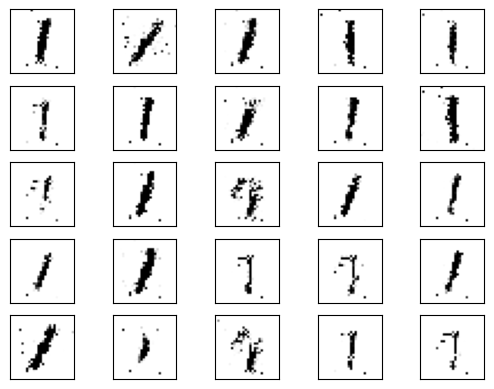

In [ ]:
# train_GAN_model
def train_GAN_model(generator=generator, discriminator=discriminator, load_weights=False):
    total_training_time = 0
    # Load pre-trained weights for the generator and discriminator using pickle
    if load_weights:
        generator = pickle.load(open('generator.pkl', 'rb'))
        discriminator = pickle.load(open('discriminator.pkl', 'rb'))
    for epoch in range(epochs):
        ETA = (epochs-epoch-1)*(total_training_time/(epoch+1))
        me, se = divmod(ETA, 60)
        he, me = divmod(me, 60)
        print(f"Epoch: {epoch+1}/{epochs}   ETA: {int(he):02d}:{int(me):02d}:{int(se):02d}")
        # Measure the start time
        start_time = time.time()
        for n, (real_samples, _) in enumerate(train_loader):
            # Show progress
            print(f"\rProgress: [{'# ' * int(20 * (n / len(train_loader)))}{'__' * (20 - int(20 * (n / len(train_loader))))}] {int(100 * (n / len(train_loader)))}%", end="")
            # Move the data to the specified device
            real_samples = real_samples.to(device=device)
            # Create labels for the real samples (all ones)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            # Generate random latent space samples
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            # Generate fake samples using the generator
            generated_samples = generator(latent_space_samples)
            # Create labels for the generated samples (all zeros)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            # Concatenate the real and generated samples and their labels
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # Train the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            discriminator_optimizer.step()

            # Generate new random latent space samples
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Train the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            generator_optimizer.step()

        # Measure the train time and compute the elapsed time
        end_time = time.time()
        elapsed_time = end_time - start_time
        total_training_time += elapsed_time
        m, s = divmod(elapsed_time, 60)
        h, m = divmod(m, 60)
        print(f"\rElapsed time: {int(h):02d}:{int(m):02d}:{int(s):02d}")

        # Print the losses
        print(f"\rLoss D.: {loss_discriminator} Loss G.: {loss_generator}")
        # Save the trained weights for the generator and discriminator using pickle
        pickle.dump(generator, open('generator.pkl', 'wb'))
        pickle.dump(discriminator, open('discriminator.pkl', 'wb'))
        test()
    # Convert total training time to hours, minutes, and seconds
    m, s = divmod(total_training_time, 60)
    h, m = divmod(m, 60)
    print(f"\nTotal training time: {int(h):02d}:{int(m):02d}:{int(s):02d}")

# Train the model for the specified number of epochs
train_GAN_model(load_weights=True)

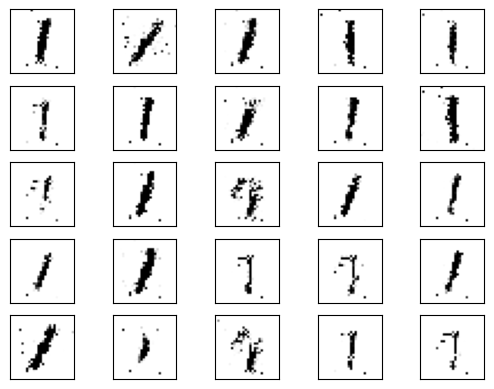

In [ ]:
test()
